In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from torch.utils.data import DataLoader, TensorDataset
from functions import Solution, Rossler, plot, LV
from models import Autoencoder, integrator, network
from dynamical_models import PolySindyModel, PredatorPrey
import torch.nn.functional as F
from sindy_utils import sindy_simulate

In [2]:
b1, b2, a12, a21 = 2/3, 1, 4/3, 1
h = 0.1
t = np.arange(0, 100, h)
n = len(t)
x0 = [1, 1.5]
xs, ys = Solution(LV, x0, t, [b1, b2, a12, a21])
tau = 15

sol = Solution(LV, x0, t, [b1, b2, a12, a21])
library = ps.PolynomialLibrary(degree=2)
model = ps.SINDy(feature_library=library,
                 optimizer=ps.STLSQ(threshold=0.05),
                 feature_names=["x", "y"])

model.fit(sol.T, t)
model.print()

LV_coefs = model.coefficients()

(x)' = 0.664 x + -1.329 x y
(y)' = -0.996 y + 0.996 x y


In [3]:
pp = PredatorPrey(args = [2/3, 1, 4/3, 1])
system = pp.f
X = odeint(system, x0, t, args = ())
x_input = X[:,0]
layer_dims = [2, 40, 10, 2]
tstep_pred = 35

In [4]:
ode_model = integrator(tstep_pred, 0.1, system=system, init_params=np.zeros_like(LV_coefs))
encoder = network(layer_dims=layer_dims, activation= F.elu)
decoder = network(layer_dims=layer_dims[::-1], activation=F.elu)

optim_enc = torch.optim.Adam(encoder.parameters(), lr = 1e-3)
optim_ode = torch.optim.Adam(ode_model.parameters(), lr = 1e-2)
loss_fn = nn.MSELoss()

In [5]:
v1 = np.array(xs[0: n - 2*tau]) #x(t)
v2 = np.array(xs[tau: n - tau]) #x(t + τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])

v = torch.tensor(np.array([v1, v2]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2]), dtype=torch.float32, requires_grad=True).T
dataset = TensorDataset(v, dvdt)
dataloader = DataLoader(dataset, batch_size=1500, shuffle=False)

In [6]:
torch.manual_seed(123)

In [7]:
sindyae = Autoencoder(tau, ode_model=ode_model, loss_fn=loss_fn, optim_enc=optim_enc, optim_ode=optim_ode, tstep_pred=tstep_pred,
                                  encoder=encoder, decoder=decoder,
                                  l={'x0':1, 'cons': 1, 'l1': 1e-1, 'recon': 1e-1, 'x_dot': 1e-1, 'v_dot': 1e-1})

In [8]:
for epoch in range(100):
    total_loss = 0
    for v_batch, dvdt_batch in dataloader:
        Loss = sindyae.loss(v_batch, dvdt_batch)
        Loss.backward()
        optim_enc.step()
        optim_ode.step()
        optim_enc.zero_grad()
        optim_ode.zero_grad()
        total_loss += Loss.item() 
    average_loss = total_loss / len(dataloader)
    if (epoch+1) % 10== 0:
         print(f"Epoch [{epoch+1}/{100}], Loss: {average_loss:.4f}")

Epoch [10/100], Loss: 2.7751
Epoch [20/100], Loss: 1.5429
Epoch [30/100], Loss: 1.4376
Epoch [40/100], Loss: 2.0379
Epoch [50/100], Loss: 1.9749
Epoch [60/100], Loss: 1.5031
Epoch [70/100], Loss: 1.3042
Epoch [80/100], Loss: 1.3365
Epoch [90/100], Loss: 1.4277
Epoch [100/100], Loss: 1.4769


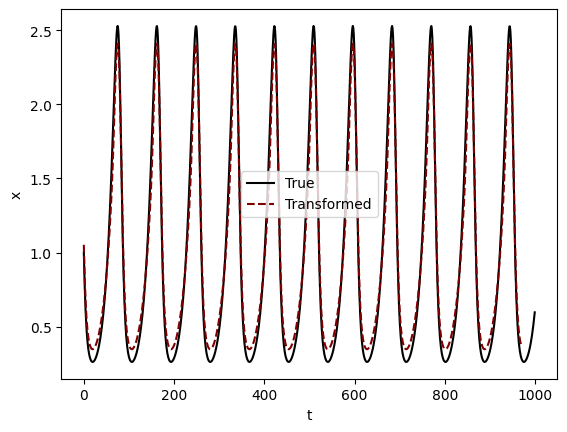

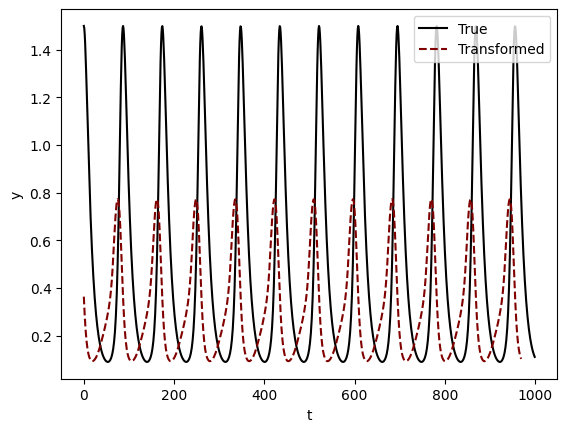

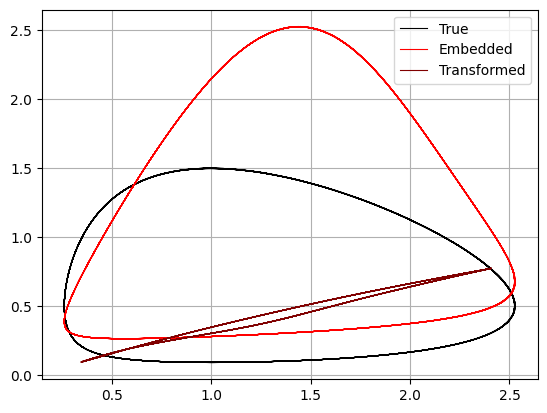

In [9]:
encoder.eval() 
ode_model.eval()
latent_variables = encoder(v)
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()


plt.plot(sol[0], color = "k", label = "True")
plt.plot(x_ae,color = "maroon", linestyle = 'dashed', label = "Transformed")
plt.ylabel("x")
plt.xlabel("t")
plt.legend()
plt.show()

plt.plot(sol[1], color = "k", label = "True")
plt.plot(y_ae,color = "maroon", linestyle = 'dashed', label = "Transformed")
plt.ylabel("y")
plt.xlabel("t")
plt.legend()
plt.show()

plt.plot(sol[0], sol[1],  color = "k", lw = .8, label = "True")
plt.plot(v1,v2,  color = "r", lw =.8, label = "Embedded")
plt.plot(x_ae, y_ae, color = "maroon", lw = .8, label = "Transformed")
plt.legend()
plt.grid()
plt.show()

(x)' = -0.787 x + 2.768 y + -62.541 x^2 + 422.071 x y + -707.836 y^2
(y)' = -0.027 x + 0.082 y + -19.529 x^2 + 131.680 x y + -220.475 y^2


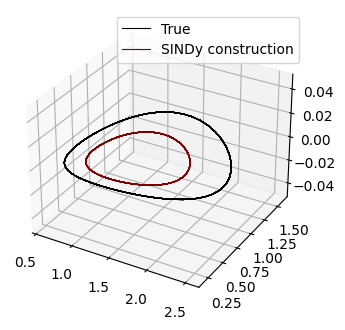

In [10]:
latent_library = ps.PolynomialLibrary(degree = 2)
latent_model = ps.SINDy(feature_library=latent_library,
                        optimizer=ps.STLSQ(threshold=0.1),
                        feature_names=["x", "y"])
latent_model.fit(latent_variables.detach().numpy(), t[:len(latent_variables.detach().numpy())])
latent_model.print()
latent_coef = latent_model.coefficients()

latent_sol = odeint(system, latent_variables[0].detach().numpy(), t, args = (latent_coef,))
fig = plt.figure(figsize=(13, 13))
ax3d = fig.add_subplot(1, 3, 1, projection='3d')
ax3d.plot(X[:,0], X[:,1], lw = .8, color = "k", label = "True")
ax3d.plot(latent_sol[:,0], latent_sol[:,1], lw = .8, color ='maroon', label = "SINDy construction")
plt.legend()
plt.show()